In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

C:\Users\septe\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.save('test_ids.npy', np.array(test_ids))
np.save('train_ids.npy', np.array(train_ids))

In [3]:
# Get train data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [4]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from tqdm import tqdm
from skimage.transform import resize

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [04:18<00:00,  2.60it/s]


In [5]:
print(X_train.shape)
print(Y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


In [6]:
# Get test data
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 30.96it/s]


In [61]:
np.save('sizes_test.npy', np.array(sizes_test))

In [56]:
np.save('X_train.npy', X_train)

In [57]:
np.save('X_test.npy', X_test)

In [58]:
np.save('Y_train.npy', Y_train)

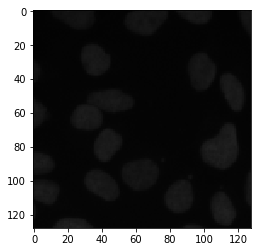

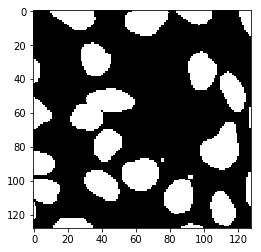

In [7]:
import random

# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]), 'gray')
plt.show()

In [13]:
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator

def setMyUnet():
        inputs = Input((128, 128, 3))
            #(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(inputs)
        print("conv1 shape:",conv1.shape)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv1)
        print("conv1 shape:",conv1.shape)
        crop1 = Cropping2D(cropping=((90,90),(90,90)))(conv1)
        print("crop1 shape:",crop1.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print("pool1 shape:",pool1.shape)

        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool1)
        print("conv2 shape:",conv2.shape)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv2)
        print ("conv2 shape:",conv2.shape)
        crop2 = Cropping2D(cropping=((41,41),(41,41)))(conv2)
        print ("crop2 shape:",crop2.shape)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print ("pool2 shape:",pool2.shape)

        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool2)
        print ("conv3 shape:",conv3.shape)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv3)
        print ("conv3 shape:",conv3.shape)
        crop3 = Cropping2D(cropping=((16,17),(16,17)))(conv3)
        print ("crop3 shape:",crop3.shape)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print ("pool3 shape:",pool3.shape)

        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        crop4 = Cropping2D(cropping=((4,4),(4,4)))(drop4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = merge([crop4,up6], mode = 'concat', concat_axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = merge([crop3,up7], mode = 'concat', concat_axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = merge([crop2,up8], mode = 'concat', concat_axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = merge([crop1,up9], mode = 'concat', concat_axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv9)

        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
        
        model = Model(input = inputs, output = conv10)

        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        return model

In [14]:
model = setMyUnet()

conv1 shape: (?, 126, 126, 64)
conv1 shape: (?, 124, 124, 64)
crop1 shape: (?, 0, 0, 64)
pool1 shape: (?, 62, 62, 64)
conv2 shape: (?, 60, 60, 128)
conv2 shape: (?, 58, 58, 128)
crop2 shape: (?, 0, 0, 128)
pool2 shape: (?, 29, 29, 128)
conv3 shape: (?, 27, 27, 256)
conv3 shape: (?, 25, 25, 256)
crop3 shape: (?, 0, 0, 256)
pool3 shape: (?, 12, 12, 256)


ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_20/convolution' (op: 'Conv2D') with input shapes: [?,2,2,1024], [3,3,1024,1024].

In [20]:
def DataGen(X_train, y_train, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255,zoom_range=0.25, 
                             rotation_range=15.,channel_shift_range=25., 
                             width_shift_range=0.02, height_shift_range=0.02,
                             horizontal_flip=True, vertical_flip = True, fill_mode='constant')
    generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
    return generator

In [28]:
from sklearn.model_selection import train_test_split

# set the random seed
random_seed = 2

batch_size = 32

# split the train and the validation set for the fitting
X_trn, X_val, y_trn, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

# Generate data
trn_generator = DataGen(X_trn, y_trn, batch_size)
val_generator = DataGen(X_val, y_val, batch_size)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 5
steps_per_epoch = 200
validation_steps = 50

# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
history_ft = model.fit_generator(
            trn_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=validation_steps,
            callbacks=[earlystopper, checkpointer])

Epoch 1/5
 12/200 [>.............................] - ETA: 1:55:46 - loss: 0.4592 - acc: 0.83 - ETA: 1:53:05 - loss: 0.4345 - acc: 0.84 - ETA: 1:50:59 - loss: 0.4467 - acc: 0.83 - ETA: 1:49:49 - loss: 0.4279 - acc: 0.84 - ETA: 1:48:53 - loss: 0.4285 - acc: 0.84 - ETA: 1:48:00 - loss: 0.4249 - acc: 0.85 - ETA: 1:47:18 - loss: 0.4276 - acc: 0.84 - ETA: 1:46:35 - loss: 0.4280 - acc: 0.84 - ETA: 1:45:55 - loss: 0.4304 - acc: 0.84 - ETA: 1:45:19 - loss: 0.4267 - acc: 0.84 - ETA: 1:44:43 - loss: 0.4279 - acc: 0.84 - ETA: 1:44:34 - loss: 0.4332 - acc: 0.8445

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()